<a href="https://colab.research.google.com/github/TheodorIvanov/ML_Group_J/blob/master/summer_project_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the data

In [1]:
from google.colab import files # insert json token

import json # alternatively can use files.upload()
dict = {"username":"tedbg41","key":"e8b997c78473e26b4bec20ca33c9ca66"}
with open('kaggle.json', 'w') as fp:
    json.dump(dict, fp)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the Zip database from Kaggle

!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzipping the file

import zipfile
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall()

 82% 54.0M/66.0M [00:01<00:00, 39.9MB/s]
100% 66.0M/66.0M [00:01<00:00, 58.7MB/s]


## Libraries and Settings


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
palette = ['#586ba4','#f68e5f','#f76c5e','#324376','#f5dd90']
sns.set_palette(palette) # https://coolors.co/palettes/trending
cont = sns.diverging_palette(25, 255, s=70, sep=1, l=50, as_cmap=True, center='light')
# sns.palplot(sns.color_palette())
sns.set_style("darkgrid")
matplotlib.rcParams.update({'font.size': 11})

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from keras.layers import *
from keras import losses
from keras import optimizers
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Supressing  Warnings

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

# Random state seed

seed = 66


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Custom Functions

In [3]:
# SVM section Functions

def Model_Performance(model, X_test, y_test, prediction, name):
  
  # Performance Metrics
  print('\n Confusion Matrix \n =================================== \n')
  sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap=cont, fmt='g', cbar=False)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.savefig(name+'_cm.svg')
  plt.show()
  print('\n Classification Report \n =================================== \n', classification_report(y_test,prediction))

  # Reciever operating characteristic (ROC) curve
  if model:
    from sklearn.metrics import plot_roc_curve
    plot_roc_curve(model, X_test, y_test)
    plt.title('ROC Graph')
    plt.plot([0,1],[0,1], color=palette[1], linestyle = '-.')
    plt.xlim([-0.02, 1])
    plt.ylim([0, 1.03])
    plt.savefig(name+'_roc.svg')
    plt.show()
  else:
    pass

def SVM_search(X_train, X_test, y_train, y_test, grid_search=True, verbose=0, jobs=1, evaluate=False,name=''):
  from sklearn.model_selection import GridSearchCV

  # Supressing the flood of Data Conversion Warnings
  import warnings
  from sklearn.exceptions import DataConversionWarning
  warnings.filterwarnings(action='ignore', category=DataConversionWarning)
  
  if grid_search: # if grid_search parameter is True then

    # SVM Classifiers
    kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']

    #A function which returns the corresponding SVC model
    def getClassifier(ktype):
        if ktype == 0:
            # Polynomial kernal
            return SVC(kernel='poly', degree=8, gamma="auto")
        elif ktype == 1:
            # Radial Basis Function kernal
            return SVC(kernel='rbf', gamma="auto")
        elif ktype == 2:
            # Sigmoid kernal
            return SVC(kernel='sigmoid', gamma="auto")
        elif ktype == 3:
            # Linear kernal
            return SVC(kernel='linear', gamma="auto")

    for i in range(4):
      # Train a SVC model using different kernal
      svclassifier = getClassifier(i) 
      svclassifier.fit(X_train, y_train)
      # Make prediction
      y_pred = svclassifier.predict(X_test)
      # Evaluate our model
      if evaluate:
        print("Evaluation:", kernels[i], "kernel")  # Can be uncommented for further details
        print(classification_report(y_test,y_pred))
      else:
        pass

    # Setting the Search Parameters
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
    
    # Performing the Grid Search
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=verbose, n_jobs=jobs)
    model = grid.fit(X_train,y_train)

    # Performance Metrics
    
    print('\n Best Estimator Model \n =================================== \n', grid.best_estimator_)
    grid_predictions = grid.predict(X_test)
    Model_Performance(model = model, X_test = X_test, y_test = y_test, prediction = grid_predictions, name=name)

  else:
    # Performing the Standard Model
    model = svm.SVC().fit(X_train, y_train)
    prediction = model.predict(X_test)

    # Performance Metrics
    print('\n Model Parameters \n ====================================================================== \n', model.get_params())
    Model_Performance(model = model, X_test = X_test, y_test=y_test, prediction=prediction,name=name)

# Autoencoder section Functions

def LossGraph(history, name):
  plt.figure(figsize = (10,8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.savefig(name+'_loss.svg')
  plt.show();

def ReconstructionScatter(cleared, frauds, threshold, name): 
  plt.figure(figsize = (12,9))
  plt.scatter(cleared.index, cleared.values, marker = 'o', label = 'Cleared')
  plt.scatter(frauds.index, frauds.values, marker = 'x', label = 'Flagged')
  plt.hlines(threshold, plt.xlim()[0], plt.xlim()[1], colors = palette[2], label = 'Threshold')
  plt.legend(loc = 'best')
  plt.title('Reconstructed Transactions')
  plt.xlabel('Transaction ID')
  plt.ylabel('Root Reconstruction Error')
  plt.savefig(name+'_scatter.svg')
  plt.show();

def ModelPerformance(X_test, y_test, prediction, name):
  print('\n Confusion Matrix \n =================================== \n')
  sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap=cont, fmt='g', cbar=False)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.savefig(name+'_cm.svg')
  plt.show();
  print('\n Classification Report \n =================================== \n', classification_report(y_test,prediction))

def RoC(ture_class, reconstruction_error, name):
  from sklearn.metrics import auc, roc_curve

  fpr, tpr, thresholds = roc_curve(ture_class, reconstruction_error)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(8,7))
  plt.title('ROC Graph')
  plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
  plt.legend(loc=4)
  plt.plot([0,1],[0,1], color=palette[1], linestyle = '-.')
  plt.xlim([-0.02, 1])
  plt.ylim([0, 1.03])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.savefig(name+'_RoC.svg')
  plt.show();


## Exploratory Analysis

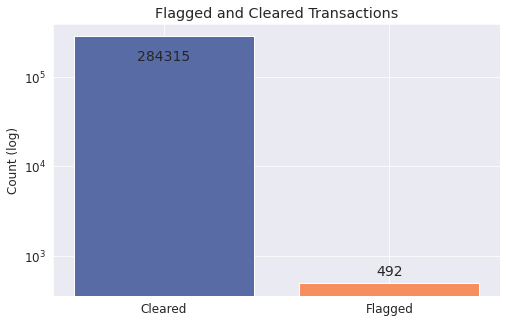

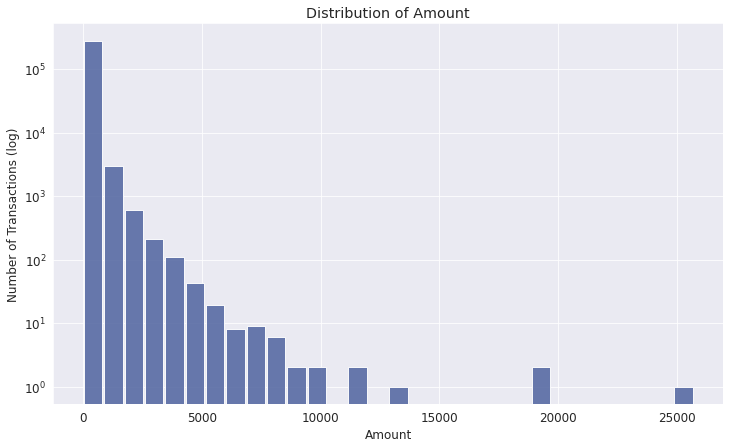

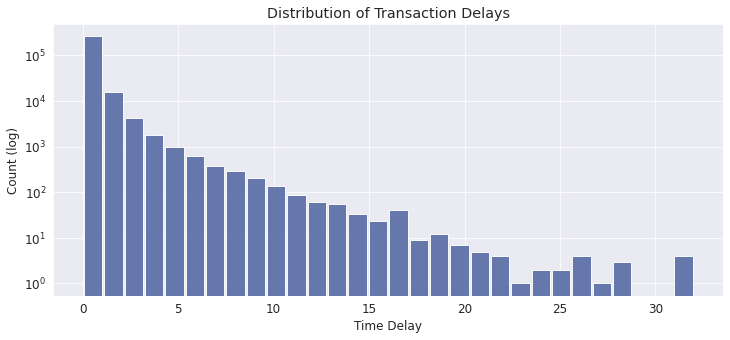

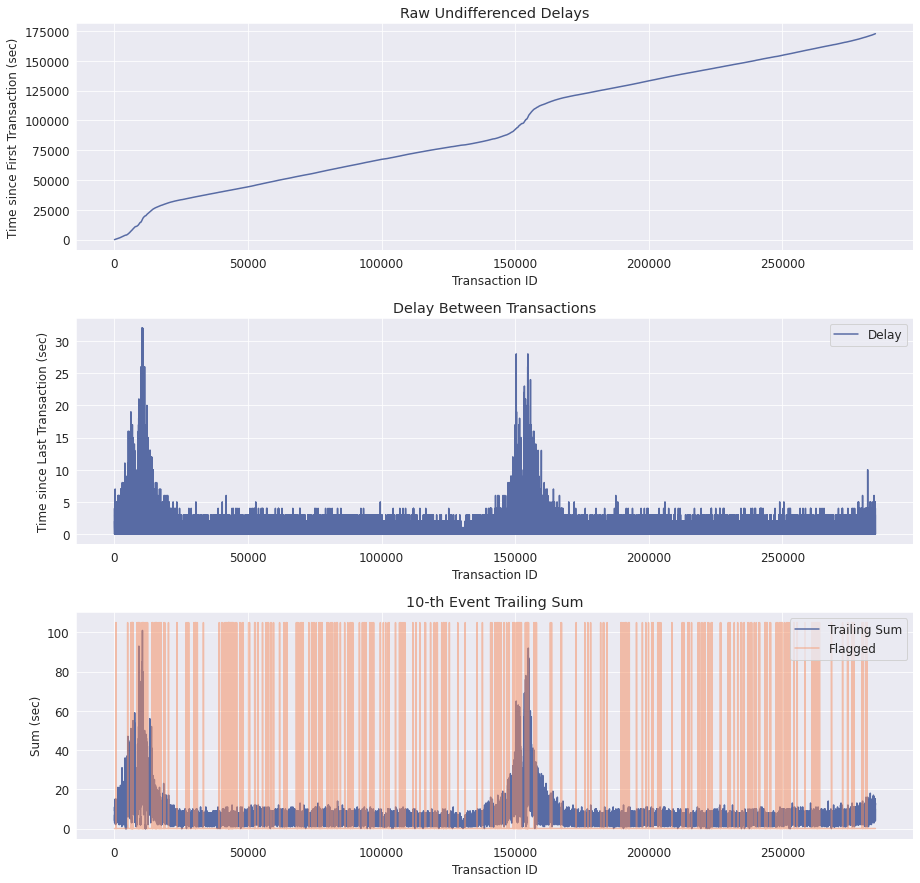

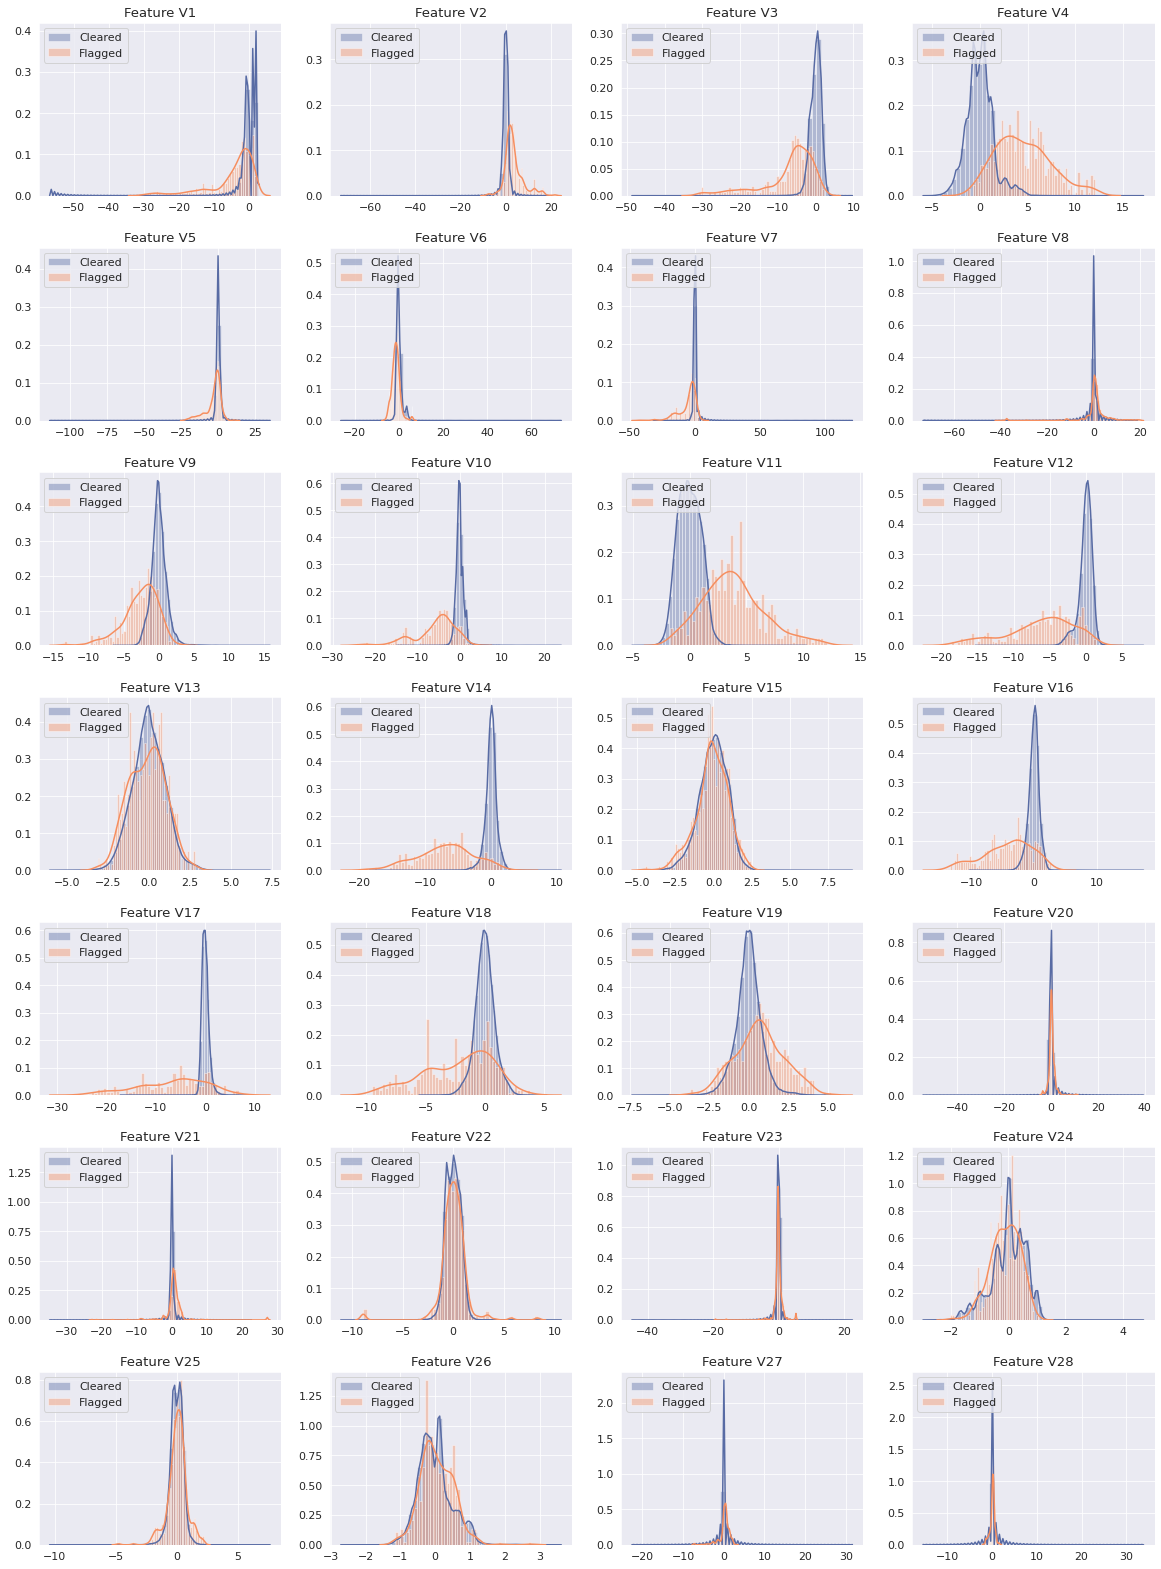

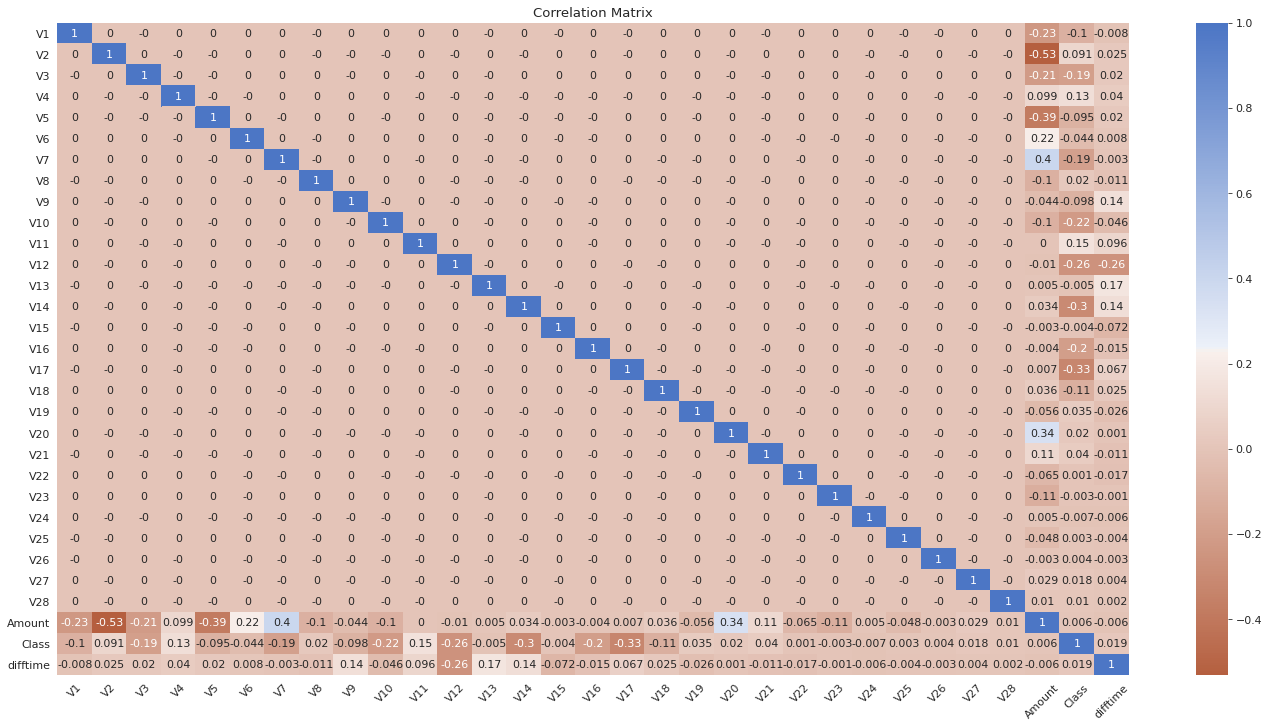

In [4]:
df = pd.read_csv('creditcard.csv')
matplotlib.rcParams.update({'font.size': 12})
# Descriptives and checking for NaNs

# print('\n Shape \n =================================== \n',  df.shape)
# print('\n Data types \n =================================== \n', df.dtypes)
# print('\n Checking for NANs \n =================================== \n', df.isnull().sum())

# Differencing with Lag = 1 to measure the time intervals between each transaction

df['difftime'] = np.insert(np.diff(df['Time'], n=1),0,0) 

# Plotting the time intervals and flagged transactions

plt.figure(figsize=(8,5))
plt.bar(x=df['Class'].value_counts().index,
        height=df['Class'].value_counts().values, alpha = 1,
        color=sns.color_palette(),log=True)
plt.text(0,150000, str(df['Class'].value_counts().values[0]),
         fontsize = 14, horizontalalignment='center')
plt.text(1,600, str(df['Class'].value_counts().values[1]),
         fontsize = 14, horizontalalignment='center')
plt.title('Flagged and Cleared Transactions')
plt.ylabel('Count (log)')
plt.grid(True)
plt.xticks([0,1],['Cleared', 'Flagged'])
plt.savefig('counts.svg')

plt.figure(figsize=(12,7))
plt.hist(df['Amount'], bins=30, log=True, rwidth=0.9, alpha=0.9)
plt.title('Distribution of Amount')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions (log)')
plt.grid(True)
plt.savefig('amount.svg')

plt.figure(figsize=(12,5))
plt.hist(df['difftime'], bins=30, log=True, rwidth=0.9, alpha=0.9)
plt.title('Distribution of Transaction Delays')
plt.xlabel('Time Delay')
plt.ylabel('Count (log)')
plt.grid(True)
plt.savefig('delays.svg')

plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(df.Time)
plt.title('Raw Undifferenced Delays')
plt.xlabel('Transaction ID')
plt.ylabel('Time since First Transaction (sec)')

plt.subplot(312)
plt.plot(df['difftime'],alpha=1, label = 'Delay')
plt.legend(loc=1)
plt.grid(True)
plt.xlabel('Transaction ID')
plt.ylabel('Time since Last Transaction (sec)')
plt.title('Delay Between Transactions')
plt.axis('tight')

plt.subplot(313)
plt.plot(df['difftime'].rolling(10).sum(), label = 'Trailing Sum')
plt.plot(df['Class']*105, alpha=0.5, label = 'Flagged')
plt.title('10-th Event Trailing Sum')
plt.legend(loc=1)
plt.xlabel('Transaction ID')
plt.ylabel('Sum (sec)')
plt.grid(True)

plt.savefig('time_undiff_and_spots.svg')

matplotlib.rcParams.update({'font.size': 11})
# Plotting the distributions of the features by class

features = df.iloc[:,1:29].columns
plt.figure(figsize=(5*4,4*7))
gs = gridspec.GridSpec(7, 4)

for i, c in enumerate(df[features]):
 ax = plt.subplot(gs[i])
 plt.subplots_adjust(hspace=0.3)
 sns.distplot(df[c][df.Class == 0], bins=50, label='Cleared')
 sns.distplot(df[c][df.Class == 1], bins=50, label='Flagged')
 ax.set_xlabel('')
 ax.set_title('Feature ' + str(c))
 plt.legend(loc=2)
plt.savefig('distr.svg')
plt.show()

#Plotting the correlation matrix

plt.figure(figsize=(24,12))
sns.heatmap(round(df.loc[:, df.columns != 'Time'].corr(), 3),
            cmap = cont,
            annot=True)
plt.xticks(rotation=45)
plt.title('Correlation Matrix')
plt.savefig('corr.svg')
plt.show()

# Scaling the data

scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Time','Class'], axis=1)),
                      columns=df.drop(['Time','Class'], axis=1).columns) # scaling all columns apart from Time and Class
scaled['Class'] = df['Class']


## Feature Selection

In [5]:
# Using Random Forest Classifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=seed)

y = scaled['Class']
X = scaled.drop(['Class'],axis=1)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


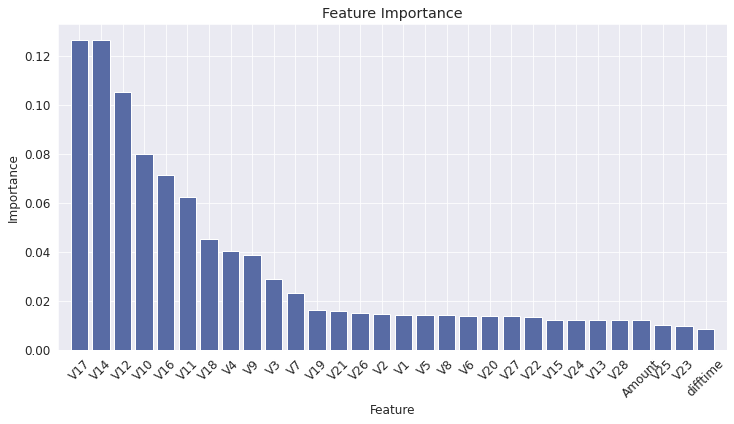

In [6]:
matplotlib.rcParams.update({'font.size': 12})
# Print the feature ranking

ordered_features = pd.DataFrame((X.iloc[:, indices].columns.values,importances[indices])).T
ordered_features.columns = ['feature','importance']

# Plot the impurity-based feature importances of the forest

plt.figure(figsize=(12,6))
plt.title("Feature Importance")
plt.bar(X.iloc[:, indices].columns.values, importances[indices],
        color = palette[0],
       #yerr=std[indices],
        align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xticks(np.arange(X.shape[1]), (X.iloc[:, indices].columns.values),rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.savefig('feature_imp.svg')
plt.show()


## SVM Models


 Model Parameters 
 {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

 Confusion Matrix 



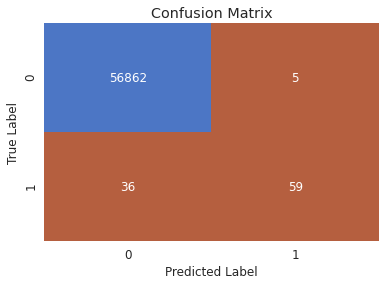


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.92      0.62      0.74        95

    accuracy                           1.00     56962
   macro avg       0.96      0.81      0.87     56962
weighted avg       1.00      1.00      1.00     56962



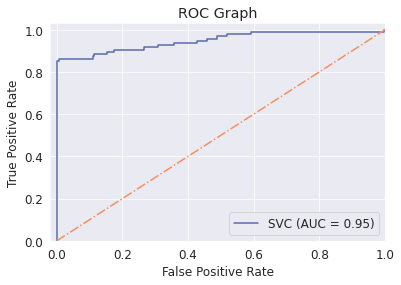


 Model Parameters 
 {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

 Confusion Matrix 



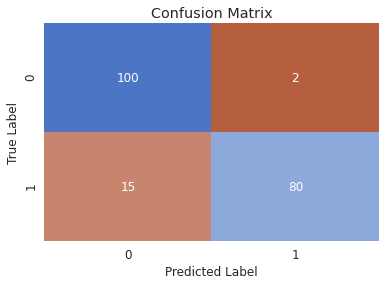


 Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       102
           1       0.98      0.84      0.90        95

    accuracy                           0.91       197
   macro avg       0.92      0.91      0.91       197
weighted avg       0.92      0.91      0.91       197



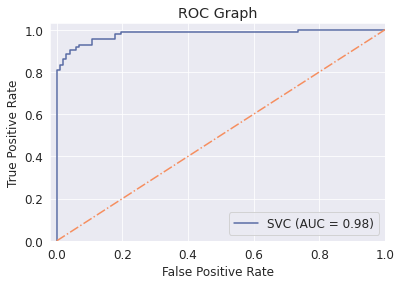


 Best Estimator Model 
 SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

 Confusion Matrix 



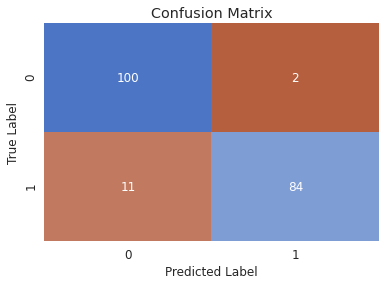


 Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       102
           1       0.98      0.88      0.93        95

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197



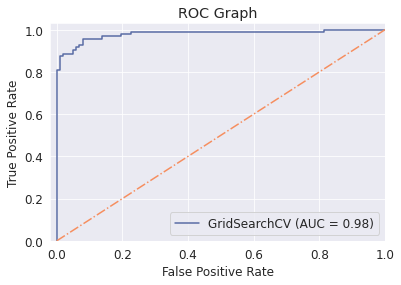


 Model 4 Parameters 
 {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 0.01, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': 66, 'shrinking': True, 'tol': 0.001, 'verbose': False}

 Confusion Matrix 



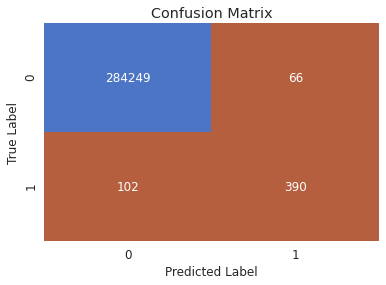


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.86      0.79      0.82       492

    accuracy                           1.00    284807
   macro avg       0.93      0.90      0.91    284807
weighted avg       1.00      1.00      1.00    284807


 Model 5 Parameters 
 {'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 66, 'shrinking': True, 'tol': 0.001, 'verbose': False}

 Using features:
 ['V3' 'V4' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18' 'Class']

 Confusion Matrix 



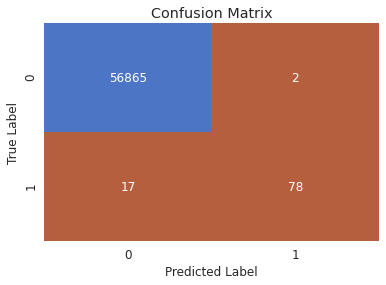


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.97      0.82      0.89        95

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962



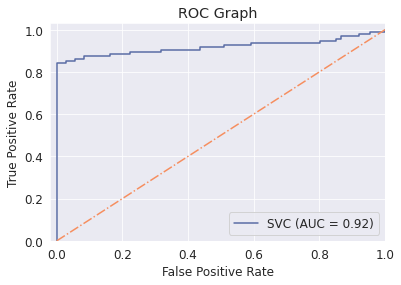

In [7]:
matplotlib.rcParams.update({'font.size': 12})

# Model 1: SVM for Normal Data

X = scaled.loc[:, scaled.columns != 'Class']
y = scaled.loc[:, scaled.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = seed)

SVM_search(X_train, X_test, y_train, y_test, grid_search=False, jobs=-1, verbose=2, name = 'SVM_norm')

# Undersampling to account for the uneven balance between Flagged and Cleared transactions

frauds = scaled[scaled.Class == 1]
cleared = scaled[scaled.Class == 0]

cleared_sample = cleared.loc[np.random.choice(cleared.index, size = len(frauds)),:] # selects a random set of cleared transactions equal to the number of frauds 

undersample = [frauds, cleared_sample]
undersample = pd.concat(undersample)

X = undersample.loc[:, undersample.columns != 'Class']
y = undersample.loc[:, undersample.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = seed)

# Models 2,3: SVM for Undersampled data

SVM_search(X_train, X_test, y_train, y_test,grid_search=False,name='SVM_undersample')
SVM_search(X_train, X_test, y_train, y_test,grid_search=True, jobs =-1,name='SVM_undersample_gs')

# Model 4: Manual Model for the Full Scaled data using the Best of the Undersampled models

X = undersample.loc[:, undersample.columns != 'Class']
y = undersample.loc[:, undersample.columns == 'Class']

X_train, _ , y_train, _  = train_test_split(X,y, train_size = 0.8, random_state = seed)

model = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=66, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

X = scaled.loc[:, scaled.columns != 'Class']
y = scaled.loc[:, scaled.columns == 'Class']

prediction = model.predict(X)

print('\n Model 4 Parameters \n ====================================================================== \n', model.get_params())
Model_Performance(False, False, y, prediction, 'SVM_undersample_full')

# Model 5: Using Selected features

fs = scaled.iloc[:, [2, 3, 8, 9, 10, 11, 13, 15, 16, 17, -1]] # selecting the features which show different distributions between cleared and flagged transactions

X = fs.loc[:, fs.columns != 'Class']
y = fs.loc[:, fs.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = seed)

model = svm.SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=66, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

prediction_svm = model.predict(X_test)

# Performance Metrics
print('\n Model 5 Parameters \n ====================================================================== \n', model.get_params())
print('\n Using features:\n', str(fs.columns.values))
Model_Performance(model, X_test, y_test, prediction_svm, name = 'SVM_featSelect')


## Autoencoder Models

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

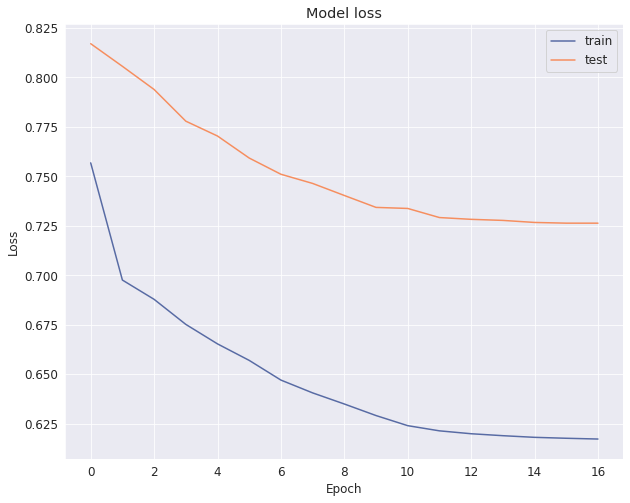

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


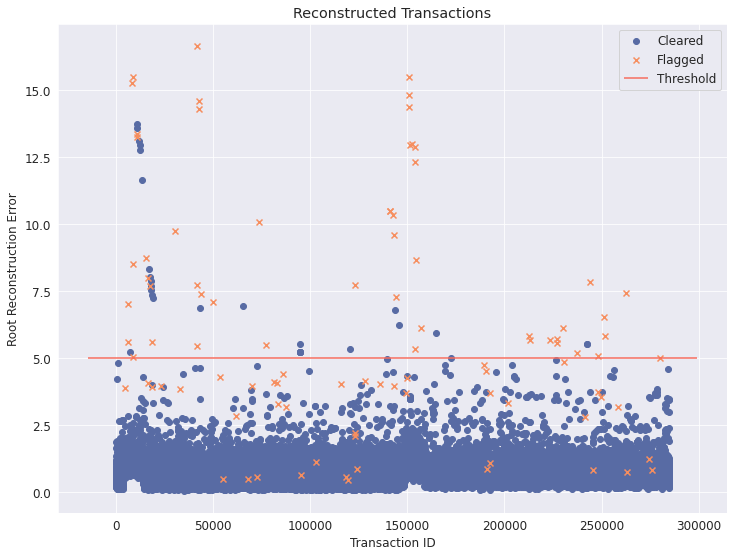


 Confusion Matrix 



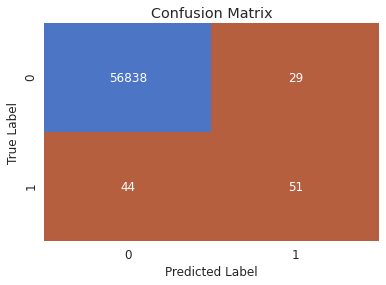


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.64      0.54      0.58        95

    accuracy                           1.00     56962
   macro avg       0.82      0.77      0.79     56962
weighted avg       1.00      1.00      1.00     56962



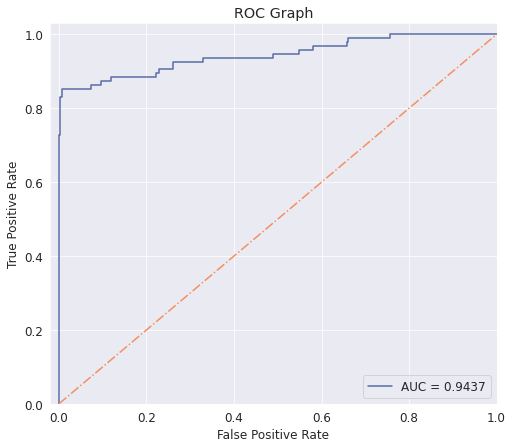

In [8]:
matplotlib.rcParams.update({'font.size': 12})

# Splitting the data

scaled = scaled[['V17','V14','V12','V10', 'V16', 'V11', 'Class']]
train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

layer1 = X_train.shape[1]
layer2 = (layer1-2)
latent = (layer2-2)

batch_size = 128
epochs = 100

# Defining the Model
name = 'autoencoder1'
inputs = Input(shape=(input_dim,), name = 'input_encoder')

encoder = Dense(layer1, activation='relu')(inputs) #18
encoder = Dense(layer2, activation='relu')(encoder) #12

bottleneck  = Dense(latent, activation='relu')(encoder)

decoder = Dense(layer2, activation='relu')(bottleneck)
decoder = Dense(layer1, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_1 = Model(inputs,decoder)
autoencoder_1.summary()
keras.utils.plot_model(autoencoder_1, show_shapes=True, to_file='autoencoder1_model.png')

# Compiling the model

autoencoder_1.compile(optimizer=keras.optimizers.Adam(),
                      loss = losses.mean_squared_error,
                      metrics = ['mae','accuracy'])

# Early Stopper

stopper = EarlyStopping(monitor = 'val_loss',
                        min_delta = 0.005,
                        verbose = 1,
                        patience = 5,
                        restore_best_weights = True)

# Training

history = autoencoder_1.fit(X_train, X_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 2,
                            validation_data = (X_test, X_test),
                            callbacks = [stopper])

LossGraph(history, name=name)

# Predicting

predictions = autoencoder_1.predict(X_test)

# Reconstruction error (RMSE)

rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# Reconstructed data

reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# Predicting the class using the threshtold

threshold = 5

reconstructed['pred_class'] = 0
reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# Model Performance

ReconstructionScatter(cleared, frauds, threshold = threshold,name=name)
ModelPerformance(X_test, y_test, reconstructed.pred_class,name=name)
RoC(reconstructed.true_class, reconstructed.rec_error,name=name)


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   [(None, 6)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                105       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_8 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 96        
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1777/1777 - 3s - loss: 0.6061 - mae: 0.4814 - accuracy: 0.7134 - val_loss: 0.6548 - val_mae: 0.4345 - val_accu

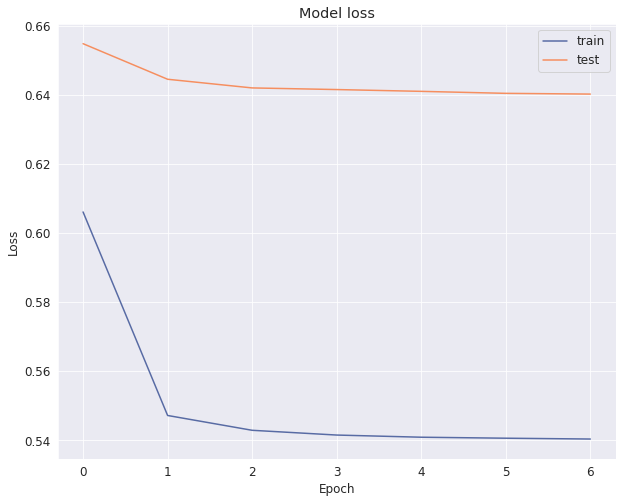

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


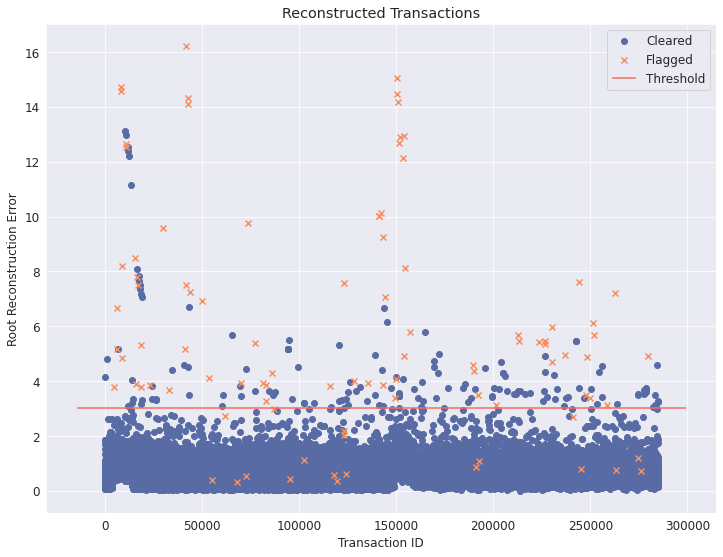


 Confusion Matrix 



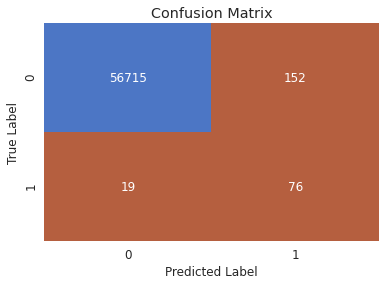


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.33      0.80      0.47        95

    accuracy                           1.00     56962
   macro avg       0.67      0.90      0.73     56962
weighted avg       1.00      1.00      1.00     56962



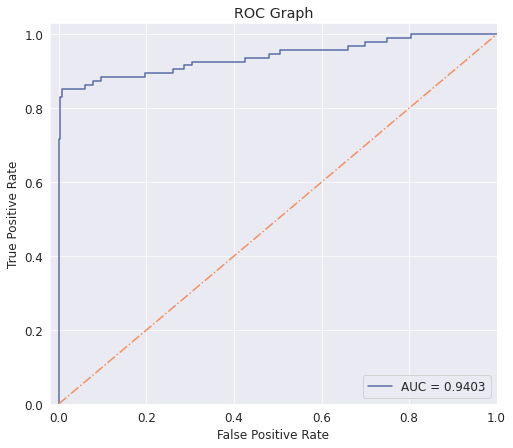

In [9]:
# Feature Selection
matplotlib.rcParams.update({'font.size': 12})
name = 'autoencoder_custom'
scaled = scaled[['V17','V14','V12','V10', 'V16', 'V11', 'Class']]

# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

latent = 5 # dimension of the latent vector 5 
batch_size = 128 # 128
epochs = 100
reg = 0.001 # regularisation parameter

# Defining the Model

inputs = Input(shape=(input_dim,), name = 'input_encoder')
encoder = Dense(15, activation='relu', activity_regularizer = regularizers.l2(reg))(inputs) # 6
bottleneck  = Dense(latent, activation='relu', activity_regularizer = regularizers.l2(reg))(encoder)
decoder = Dense(15, activation='relu', activity_regularizer = regularizers.l2(reg))(bottleneck)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_2 = Model(inputs,decoder)
autoencoder_2.summary()
keras.utils.plot_model(autoencoder_2, show_shapes=True,to_file='autoencoder_custom_model.png')

# Compiling the model

autoencoder_2.compile(optimizer=keras.optimizers.Adam(),
                      loss = losses.mean_squared_error, # mse
                      metrics = ['mae','accuracy'])

# Early Stopper

stopper = EarlyStopping(monitor = 'val_loss',
                        min_delta = 0.005,
                        verbose = 1,
                        patience = 5,
                        restore_best_weights = True)

# Training

history = autoencoder_2.fit(X_train, X_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 2,
                            validation_data = (X_test, X_test),
                            callbacks = [stopper])

LossGraph(history,name=name)

# Predicting

prediction_nns = autoencoder_2.predict(X_test)

# Reconstruction error (RMSE)

rmse = np.sqrt(np.mean(np.power(X_test - prediction_nns, 2), axis = 1))

# Reconstructed data

reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# Predicting the class using the threshtold

threshold = 3

reconstructed['pred_class'] = 0
reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# Model Performance

ReconstructionScatter(cleared, frauds, threshold = threshold,name=name)
ModelPerformance(X_test, y_test, reconstructed.pred_class,name=name)
RoC(reconstructed.true_class, reconstructed.rec_error,name=name)

## Decision Maker

In [10]:
# reconstructed['svm'] = prediction_svm
# reg_data = reconstructed.drop('rec_error', axis = 1)
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=seed).fit(reg_data[['svm','pred_class']], reg_data.true_class)

# reg_data['reg'] = clf.predict(reg_data[['svm','pred_class']])


# ModelPerformance(reg_data[['svm','pred_class']], reg_data.true_class, reg_data['reg'])
# RoC(reg_data.true_class, reg_data['reg'])